<span style="font-size: 220%;color:#1155cc"> Pytorch: EMBEDDING #2 Stroke
    
<span style="font-size: 180%;color:red"> 17.09.2020      

Classification Example using a neural network with embedding

In [1]:
import time
start_time = time.time() ## pomiar czasu: start pomiaru czasu
print(time.ctime())

Fri Sep 18 11:54:32 2020


In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### I import data

In [3]:
import pandas as pd

data = pd.read_csv('/home/wojciech/Pulpit/1/Stroke_Prediction.csv')
data.head(3)

,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
0,31153,Male,1104.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30650,Male,21204.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,17412,Female,2928.0,0,0,No,Private,Urban,110.89,17.6,NaN,0


In [4]:
data.shape

(43400, 12)

Gdy robimy model klasyfikacji zbiór musi byc zbilansowany jeżeli nie jest zbilansowany trzeba zastosowac oversampling

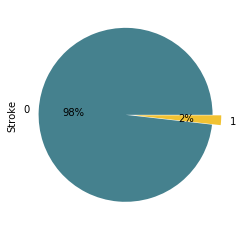

In [5]:
data.Stroke.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['#45818e', '#f1c232'], explode=(0.05, 0.05))

### I check data completeness and delete records with empty NaN values

In [6]:
data.isnull().sum()

ID                    0
Gender                0
Age_In_Days           0
Hypertension          0
Heart_Disease         0
Ever_Married          0
Type_Of_Work          0
Residence             0
Avg_Glucose           0
BMI                1462
Smoking_Status    13292
Stroke                0
dtype: int64

Observation of variables:  (43400, 12)


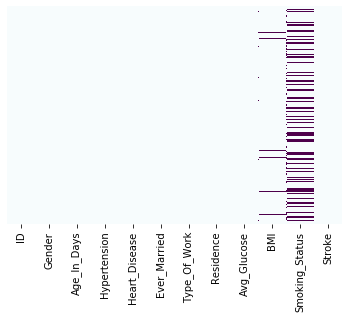

In [7]:
import seaborn as sns

print('Observation of variables: ',data.shape)
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='BuPu')

Uzupełniam braki jakim kodem, który sie odrzużnia od reszty

In [8]:
data.fillna(7777, inplace=True)

Observation of variables:  (43400, 12)


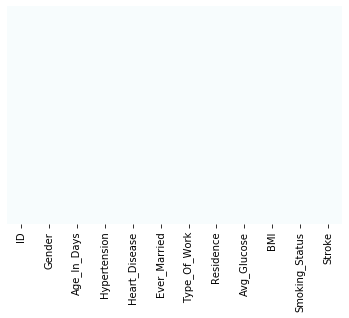

In [9]:
import seaborn as sns

print('Observation of variables: ',data.shape)
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='BuPu')

<span style="font-size: 150%;color:#1155cc"> Dziury są już zasypane ale zbiór jest niezbilansowany trzeba zastosować oversampling.
    
    To jest tylko definicja - zastosuje oversamplin jak podzielę zbiór na treningowy i testowy

In [10]:
def oversampling(ytrain, Xtrain):
    import matplotlib.pyplot as plt
    
    global Xtrain_OV
    global ytrain_OV

    calss1 = np.round((sum(ytrain == 1)/(sum(ytrain == 0)+sum(ytrain == 1))),decimals=2)*100
    calss0 = np.round((sum(ytrain == 0)/(sum(ytrain == 0)+sum(ytrain == 1))),decimals=2)*100
    
    print("y = 0: ", sum(ytrain == 0),'-------',calss0,'%')
    print("y = 1: ", sum(ytrain == 1),'-------',calss1,'%')
    print('--------------------------------------------------------')
    
    ytrain.value_counts(dropna = False, normalize=True).plot(kind='pie',title='Before oversampling')
    plt.show
    print()
    
    Proporcja = sum(ytrain == 0) / sum(ytrain == 1)
    Proporcja = np.round(Proporcja, decimals=0)
    Proporcja = Proporcja.astype(int)
       
    ytrain_OV = pd.concat([ytrain[ytrain==1]] * Proporcja, axis = 0) 
    Xtrain_OV = pd.concat([Xtrain.loc[ytrain==1, :]] * Proporcja, axis = 0)
    
    ytrain_OV = pd.concat([ytrain, ytrain_OV], axis = 0).reset_index(drop = True)
    Xtrain_OV = pd.concat([Xtrain, Xtrain_OV], axis = 0).reset_index(drop = True)
    
    Xtrain_OV = pd.DataFrame(Xtrain_OV)
    ytrain_OV = pd.DataFrame(ytrain_OV)
    

    
    print("Before oversampling Xtrain:     ", Xtrain.shape)
    print("Before oversampling ytrain:     ", ytrain.shape)
    print('--------------------------------------------------------')
    print("After oversampling Xtrain_OV:  ", Xtrain_OV.shape)
    print("After oversampling ytrain_OV:  ", ytrain_OV.shape)
    print('--------------------------------------------------------')
    
    
    ax = plt.subplot(1, 2, 1)
    ytrain.value_counts(dropna = False, normalize=True).plot(kind='pie',title='Before oversampling')
    plt.show
    
       
    kot = pd.concat([ytrain[ytrain==1]] * Proporcja, axis = 0)
    kot = pd.concat([ytrain, kot], axis = 0).reset_index(drop = True)
    ax = plt.subplot(1, 2, 2)
    kot.value_counts(dropna = False, normalize=True).plot(kind='pie',title='After oversampling')
    plt.show

### I delete several columns and empty records in Age columns


In [11]:
#del df['Unnamed: 0']
del data['ID']

In [12]:
data=data.dropna(how='any')

In [13]:
data.isnull().sum()

Gender            0
Age_In_Days       0
Hypertension      0
Heart_Disease     0
Ever_Married      0
Type_Of_Work      0
Residence         0
Avg_Glucose       0
BMI               0
Smoking_Status    0
Stroke            0
dtype: int64

<span style="font-size: 220%;color:#1155cc"> Układ kolumn z danymi kategorycznymi i ciągłymi

In [14]:
data.columns

Index(['Gender', 'Age_In_Days', 'Hypertension', 'Heart_Disease',
       'Ever_Married', 'Type_Of_Work', 'Residence', 'Avg_Glucose', 'BMI',
       'Smoking_Status', 'Stroke'],
      dtype='object')

<span style="font-size: 150%;color:#1155cc"> Prosta wersja podziału na dyskretne i ciągłe

<span style="font-size: 150%;color:#1155cc"> Teraz koduje zmienne literowe na zmienne cyfrowe

### Tool for automatic coding of discrete variables !

In [15]:
a,b = data.shape     #<- ile mamy kolumn
b

print('DISCRETE FUNCTIONS CODED')
print('------------------------')
for i in range(0,b):
    i = data.columns[i]
    f = data[i].dtypes
    if f == np.object:
        print(i,"---",f)   
    
        if f == np.object:
        
            data[i] = pd.Categorical(data[i]).codes
        
            continue

DISCRETE FUNCTIONS CODED
------------------------
Gender --- object
Ever_Married --- object
Type_Of_Work --- object
Residence --- object
Smoking_Status --- object


In [16]:
data.dtypes

Gender               int8
Age_In_Days       float64
Hypertension        int64
Heart_Disease       int64
Ever_Married         int8
Type_Of_Work         int8
Residence            int8
Avg_Glucose       float64
BMI               float64
Smoking_Status       int8
Stroke              int64
dtype: object

In [17]:
data.head(5)

,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
0,1,1104.0,0,0,0,4,0,95.12,18.0,0,0
1,1,21204.0,1,0,1,2,1,87.96,39.2,2,0
2,0,2928.0,0,0,0,2,1,110.89,17.6,0,0
3,0,25578.0,0,0,1,2,0,69.04,35.9,1,0
4,1,5128.0,0,0,0,1,0,161.28,19.1,0,0


<span style="font-size: 180%;color:#1155cc">oversampling
    
    Przyjąłem taki założenie, że najpierw podziele populację na zbiór testowy i treningow. 
    Następnie zbiór treningowy poddam oversampling. W dalszej części zostaje zastosowany jako polulacja do trenowania sieci neuronowych.  Zbiór testowy stanowiący 10% wielkości całej populacji zostaje odstawiony na bok. Na końcu zgrywam model sieci neuronowych z dysku i stosuje go do tych 10% danych odstawionych teraz na bok.
  

In [18]:
X = data.drop('Stroke', axis=1) 
y = data['Stroke']  

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=123,stratify=y)
# Jeżeli się rzuca wtedy wycinamy stratify=y.

y = 0:  38355 ------- 98.0 %
y = 1:  705 ------- 2.0 %
--------------------------------------------------------

Before oversampling Xtrain:      (39060, 10)
Before oversampling ytrain:      (39060,)
--------------------------------------------------------
After oversampling Xtrain_OV:   (77130, 10)
After oversampling ytrain_OV:   (77130, 1)
--------------------------------------------------------


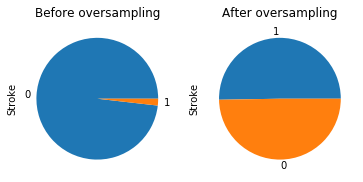

In [19]:
oversampling(y_train, X_train)

In [20]:
df = pd.merge(Xtrain_OV,ytrain_OV, how='inner', left_index=True, right_index=True)

In [21]:
df

,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
0,0,3681.0,0,0,0,4,1,94.86,24.6,2,0
1,0,16826.0,0,0,1,0,1,108.26,25.7,2,0
2,1,12435.0,0,0,1,3,0,98.83,26.5,2,0
3,0,20827.0,0,0,1,2,1,90.13,39.9,1,0
4,0,772.0,0,0,0,4,0,121.32,24.1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
77125,0,24492.0,0,0,1,2,1,189.69,7777.0,2,1
77126,1,29978.0,0,0,1,2,0,108.70,22.5,2,1
77127,0,28863.0,0,1,1,3,0,85.22,23.6,2,1
77128,0,24868.0,1,0,0,3,1,79.79,29.7,2,1


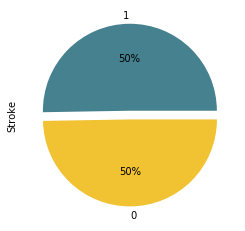

In [22]:
df.Stroke.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['#45818e', '#f1c232'], explode=(0.05, 0.05))

  Dziele zbiór na zmienne dyskretne i ciągłe bo zmienne dyskretne będa poddane EMBEDDING.

<span style="font-size: 150%;color:#1155cc"> Mojej produkcji podziału na dyskretne i ciągłe
    
    
Które z tych funkcji są kategoryczne?

Stawiam dwa warunki: 

1. funkcja jest kategoryczna bo ma format 'object'
2. funkcja jest kategoryczna bo ma do 24 unikalnych wartości

In [23]:
a,b = df.shape     #<- ile mamy kolumn
b

print('ONLY DISCRETE FUNCTION')
print('----------------------')
for i in range(0,b):
    i = df.columns[i]
    f = df[i].dtypes
    h = df[i].nunique()
    
    if f == np.object or h<=24:
        print(i,"---",f,"---",h)

ONLY DISCRETE FUNCTION
----------------------
Gender --- int8 --- 3
Hypertension --- int64 --- 2
Heart_Disease --- int64 --- 2
Ever_Married --- int8 --- 2
Type_Of_Work --- int8 --- 5
Residence --- int8 --- 2
Smoking_Status --- int8 --- 4
Stroke --- int64 --- 2


In [24]:
df.columns

Index(['Gender', 'Age_In_Days', 'Hypertension', 'Heart_Disease',
       'Ever_Married', 'Type_Of_Work', 'Residence', 'Avg_Glucose', 'BMI',
       'Smoking_Status', 'Stroke'],
      dtype='object')

<span style="font-size: 150%;color:#1155cc"> Robie to ręcznie - może potem zrobie do tego automat
    
    Ręcznie przyporządkowuje kolumny do kategorii zmiennych dyskretnych (categorycznych) i zmiennych ciągłych (numerycznych)

In [25]:
categorical_columns = ['Gender', 'Hypertension', 'Heart_Disease', 'Ever_Married', 'Type_Of_Work',
       'Residence','Smoking_Status']
numerical_columns = ['Age_In_Days', 'Avg_Glucose','BMI']

In [26]:
df['Age_In_Days'].value_counts()

28844.0    285
28879.0    231
29567.0    230
28873.0    227
28493.0    184
          ... 
47.2         1
607.4        1
525.0        1
645.6        1
139.8        1
Name: Age_In_Days, Length: 4786, dtype: int64

### We determine that the output variable is the 'Stroke' column

In [27]:
outputs = ['Stroke']

### Digitization of text variables

In [28]:
df.dtypes

Gender               int8
Age_In_Days       float64
Hypertension        int64
Heart_Disease       int64
Ever_Married         int8
Type_Of_Work         int8
Residence            int8
Avg_Glucose       float64
BMI               float64
Smoking_Status       int8
Stroke              int64
dtype: object

We need to convert types for qualitative columns to category. We can do this using the astype () function, as shown below:

<span style="font-size: 150%;color:#1155cc"> Zmieniam format zmiennych kategorycznych type: 'category'</span>

In [29]:
for category in categorical_columns:
    df[category] = df[category].astype('category')

In [30]:
df.dtypes

Gender            category
Age_In_Days        float64
Hypertension      category
Heart_Disease     category
Ever_Married      category
Type_Of_Work      category
Residence         category
Avg_Glucose        float64
BMI                float64
Smoking_Status    category
Stroke               int64
dtype: object

### Digitization of data

### Why did we digitize data in the format?

Podstawowym celem oddzielania kolumn kategorialnych od kolumn liczbowych jest to, że wartości w kolumnie liczbowej mogą być bezpośrednio wprowadzane do sieci neuronowych. Jednak wartości kolumn skategoryzowanych należy najpierw przekonwertować na typ liczbowy.

In [31]:
categorical_columns

['Gender',
 'Hypertension',
 'Heart_Disease',
 'Ever_Married',
 'Type_Of_Work',
 'Residence',
 'Smoking_Status']

### Conversion of categorical variables to Numpy matrix

In [32]:
p1 = df['Gender'].cat.codes.values
p2 = df['Hypertension'].cat.codes.values
p3 = df['Heart_Disease'].cat.codes.values
p4 = df['Ever_Married'].cat.codes.values
p5 = df['Type_Of_Work'].cat.codes.values
p6 = df['Residence'].cat.codes.values
p7 = df['Smoking_Status'].cat.codes.values


NumP_matrix = np.stack([p1,p2,p3,p4,p5,p6,p7], 1)   

NumP_matrix[:10]


array([[0, 0, 0, 0, 4, 1, 2],
       [0, 0, 0, 1, 0, 1, 2],
       [1, 0, 0, 1, 3, 0, 2],
       [0, 0, 0, 1, 2, 1, 1],
       [0, 0, 0, 0, 4, 0, 0],
       [0, 0, 0, 1, 2, 0, 3],
       [0, 0, 0, 0, 4, 1, 1],
       [1, 0, 0, 0, 4, 1, 0],
       [0, 0, 0, 0, 0, 1, 2],
       [0, 0, 0, 1, 2, 0, 2]], dtype=int8)

### Odpalam karte graficzną GPU

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Creating a Pytorch tensor from the Numpy matrix

In [34]:
categorical_data = torch.tensor(NumP_matrix, dtype=torch.int64, device=device)
categorical_data[:10]

tensor([[0, 0, 0, 0, 4, 1, 2],
        [0, 0, 0, 1, 0, 1, 2],
        [1, 0, 0, 1, 3, 0, 2],
        [0, 0, 0, 1, 2, 1, 1],
        [0, 0, 0, 0, 4, 0, 0],
        [0, 0, 0, 1, 2, 0, 3],
        [0, 0, 0, 0, 4, 1, 1],
        [1, 0, 0, 0, 4, 1, 0],
        [0, 0, 0, 0, 0, 1, 2],
        [0, 0, 0, 1, 2, 0, 2]], device='cuda:0')

### Conversion of DataFrame numeric columns to a Pytorch tensor

In [35]:
numerical_data = np.stack([df[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float, device=device)
numerical_data[:5]

tensor([[ 3681.0000,    94.8600,    24.6000],
        [16826.0000,   108.2600,    25.7000],
        [12435.0000,    98.8300,    26.5000],
        [20827.0000,    90.1300,    39.9000],
        [  772.0000,   121.3200,    24.1000]], device='cuda:0')

### Convert result variables to the Pytorch tensor

In [36]:
outputs = torch.tensor(df[outputs].values).flatten()
outputs = torch.tensor(outputs, device=device)
outputs[:5]

/home/wojciech/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor([0, 0, 0, 0, 0], device='cuda:0')

### Let's sum up the tensors

In [37]:
print('categorical_data: ',categorical_data.shape)
print('numerical_data:   ',numerical_data.shape)
print('outputs:          ',outputs.shape)

categorical_data:  torch.Size([77130, 7])
numerical_data:    torch.Size([77130, 3])
outputs:           torch.Size([77130])


## <span style="color:red">settlement</span>
Przekształciliśmy nasze kolumny kategorialne na liczbowe, w których unikalną wartość reprezentuje jedna liczba całkowita (cyfryzacja - np. Palacz to 1). Na podstawie takiej kolumny (zmiennej) możemy trenować model, ale jest lepszy sposób ...

Lepszym sposobem jest przedstawienie wartości w kolumnie jakościowej jako N-wymiarowego wektora zamiast pojedynczej liczby całkowitej. Ten proces nazywa się osadzaniem. Wektor jest w stanie uchwycić więcej informacji i może znaleźć relacje między różnymi wartościami kategorialnymi w bardziej odpowiedni sposób. Dlatego będziemy przedstawiać wartości w kolumnach kategorialnych w postaci wektorów N-wymiarowych.

Musimy zdefiniować rozmiar osadzania (wymiary wektora) dla wszystkich kolumn jakościowych. Nie ma sztywnej zasady dotyczącej liczby wymiarów. Dobrą zasadą definiowania rozmiaru osadzania dla kolumny jest podzielenie liczby unikalnych wartości w kolumnie przez 2 (ale nie więcej niż 50).

Poniższy skrypt tworzy krotkę zawierającą liczbę unikalnych wartości i rozmiary wymiarów dla wszystkich kolumn jakościowych (dyskretnych).

Zasada jest prosta: w matrycy osadzającej (categorical_embedding_sizes) musi zawsze znajdować się liczba wierszy większa niż zakres zmiennych w liczbie wierszy: dlatego dodałem col_size + 2, to duży zapas.

In [38]:
categorical_column_sizes = [len(df[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size+2, min(50, (col_size+5)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(5, 4), (4, 3), (4, 3), (4, 3), (7, 5), (4, 3), (6, 4)]


### Dzielenie zestawu na szkoleniowy i testowy

In [39]:
total_records = df['Age_In_Days'].count()
test_records = int(total_records * .2)   # to 20% będzie zbiorem tesowym

categorical_train_data = categorical_data[:total_records-test_records]
categorical_test_data = categorical_data[total_records-test_records:total_records]
numerical_train_data = numerical_data[:total_records-test_records]
numerical_test_data = numerical_data[total_records-test_records:total_records]
train_outputs = outputs[:total_records-test_records]
test_outputs = outputs[total_records-test_records:total_records]

Aby sprawdzić, czy poprawnie podzieliliśmy dane na zestawy treningów i testów, wydrukujmy długości rekordów szkolenia i testów:

In [40]:
print('categorical_train_data: ',categorical_train_data.shape)
print('numerical_train_data:   ',numerical_train_data.shape)
print('train_outputs:          ', train_outputs.shape)
print('----------------------------------------------------')
print('categorical_test_data:  ',categorical_test_data.shape)
print('numerical_test_data:    ',numerical_test_data.shape)
print('test_outputs:           ',test_outputs.shape)

categorical_train_data:  torch.Size([61704, 7])
numerical_train_data:    torch.Size([61704, 3])
train_outputs:           torch.Size([61704])
----------------------------------------------------
categorical_test_data:   torch.Size([15426, 7])
numerical_test_data:     torch.Size([15426, 3])
test_outputs:            torch.Size([15426])


Zbiór jest zbilansowany bo przeszedł oversampling 

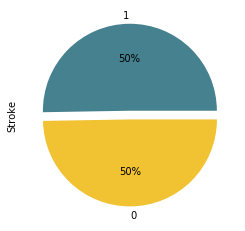

In [41]:
df.Stroke.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['#45818e', '#f1c232'], explode=(0.05, 0.05))

### Sprawdzam czy wszędzie są CUDA

In [42]:
categorical_train_data[:1]

tensor([[0, 0, 0, 0, 4, 1, 2]], device='cuda:0')

In [43]:
numerical_train_data[:1]

tensor([[3681.0000,   94.8600,   24.6000]], device='cuda:0')

In [44]:
train_outputs[:1]

tensor([0], device='cuda:0')

In [45]:
categorical_test_data[:1]

tensor([[0, 0, 0, 0, 2, 1, 0]], device='cuda:0')

In [46]:
numerical_test_data[:1]

tensor([[28108.0000,    81.3200,  7777.0000]], device='cuda:0')

In [47]:
test_outputs[:1]

tensor([1], device='cuda:0')

<span style="font-size: 130%;color:#1155cc"> Model sieci neuronwej (rozbudowany)

In [48]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

In [49]:
print('categorical_embedding_sizes:  ',categorical_embedding_sizes)
print(numerical_data.shape[1])

categorical_embedding_sizes:   [(5, 4), (4, 3), (4, 3), (4, 3), (7, 5), (4, 3), (6, 4)]
3


## Deklaruje model jako CUDA

In [50]:
model = Model(categorical_embedding_sizes, numerical_data.shape[1], 2, [200,100,50], p=0.4).to(device)

In [51]:
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(4, 3)
    (2): Embedding(4, 3)
    (3): Embedding(4, 3)
    (4): Embedding(7, 5)
    (5): Embedding(4, 3)
    (6): Embedding(6, 4)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=28, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_st

<span style="font-size: 280%;color:#1155cc"> Funkcja straty

In [52]:
#loss_function = torch.nn.MSELoss(reduction='sum')
loss_function = nn.CrossEntropyLoss()
#loss_function = nn.BCEWithLogitsLoss()

<span style="font-size: 280%;color:#1155cc"> Optymalizer

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
#optimizer = torch.optim.Rprop(model.parameters(), lr=0.05, etas=(0.5, 1.2), step_sizes=(1e-06, 50))

In [54]:
print('categorical_embedding_sizes:  ',categorical_embedding_sizes)
print(numerical_data.shape[1])
print('categorical_train_data: ',categorical_train_data.shape)
print('numerical_train_data:   ',numerical_train_data.shape)
print('outputs:                ',train_outputs.shape)

categorical_embedding_sizes:   [(5, 4), (4, 3), (4, 3), (4, 3), (7, 5), (4, 3), (6, 4)]
3
categorical_train_data:  torch.Size([61704, 7])
numerical_train_data:    torch.Size([61704, 3])
outputs:                 torch.Size([61704])


In [55]:
y_pred = model(categorical_train_data, numerical_train_data)

In [56]:
epochs = 1600
aggregated_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data, numerical_train_data)
    
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i%40 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.80503339
epoch:  41 loss: 0.44802967
epoch:  81 loss: 0.43787795
epoch: 121 loss: 0.42972946
epoch: 161 loss: 0.42105785
epoch: 201 loss: 0.41332683
epoch: 241 loss: 0.40583590
epoch: 281 loss: 0.39922306
epoch: 321 loss: 0.39183426
epoch: 361 loss: 0.38974532
epoch: 401 loss: 0.38135272
epoch: 441 loss: 0.37473223
epoch: 481 loss: 0.37017509
epoch: 521 loss: 0.36921924
epoch: 561 loss: 0.36069551
epoch: 601 loss: 0.35884485
epoch: 641 loss: 0.35529187
epoch: 681 loss: 0.35616702
epoch: 721 loss: 0.35314989
epoch: 761 loss: 0.34931317
epoch: 801 loss: 0.34590307
epoch: 841 loss: 0.34718192
epoch: 881 loss: 0.34580591
epoch: 921 loss: 0.34263346
epoch: 961 loss: 0.33622172
epoch: 1001 loss: 0.33856168
epoch: 1041 loss: 0.33831263
epoch: 1081 loss: 0.33739653
epoch: 1121 loss: 0.33242413
epoch: 1161 loss: 0.33193484
epoch: 1201 loss: 0.33401591
epoch: 1241 loss: 0.33333409
epoch: 1281 loss: 0.33284175
epoch: 1321 loss: 0.32855007
epoch: 1361 loss: 0.32970160
epoch: 140

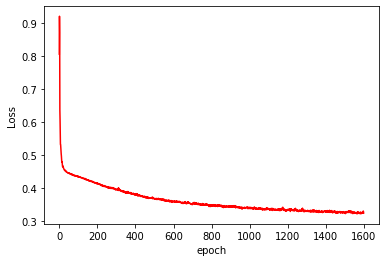

In [57]:
plt.plot(range(epochs), aggregated_losses, color='r')
plt.ylabel('Loss')
plt.xlabel('epoch');

### Forecast based on the model

In [58]:
with torch.no_grad():
    y_val_train = model(categorical_train_data, numerical_train_data)
    loss = loss_function( y_val_train, train_outputs)
print(f'Loss train_set: {loss:.8f}')

Loss train_set: 0.32747367


In [59]:
with torch.no_grad():
    y_val = model(categorical_test_data, numerical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 4.00307322


NIE POWINNO SIĘ PORÓWNYWAĆ y_val (wynik modelu), KTÓRY MA format ZMIENNYCH FLOAD do test_outputs który ma format zero-jedynkowy. 

Ponieważ ustaliliśmy, że nasza warstwa wyjściowa będzie zawierała 2 neurony, każda prognoza będzie zawierała 2 wartości. Na przykład pierwsze 5 przewidywanych wartości to:

In [60]:
print(test_outputs[:5])

tensor([1, 1, 1, 1, 1], device='cuda:0')


In [61]:
print(y_val[:5])

tensor([[ -1.1377,   1.1209],
        [  4.7003,  -4.5424],
        [  6.7803,  -4.9974],
        [ 22.6363, -16.2745],
        [  0.1678,  -0.7716]], device='cuda:0')


### ZMIANA FORMATU WYNIKÓW Z FORMATU FLOAT NA FORMAT BINARNY

Celem takich prognoz jest to, że jeśli faktyczny wynik wynosi 0, wartość wskaźnika 0 powinna być wyższa niż wartość wskaźnika 1 i odwrotnie. Możemy uzyskać największy indeks wartości z listy za pomocą następującego skryptu:

<span style="font-size: 180%;color:#1155cc"> Najpier kopiuje tensor y_val z CUDA do CPU

In [62]:
y_val[:1]

tensor([[-1.1377,  1.1209]], device='cuda:0')

In [63]:
y_val = y_val.cpu().data.numpy()

In [64]:
y_val = np.argmax(y_val, axis=1)

Powyższe równanie zwraca maksymalne wskaźniki wartości wzdłuż osi.

In [65]:
print(y_val[:20])

[1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0]


Ponieważ na liście pierwotnie przewidywanych wyników dla pierwszych pięciu rekordów wartości indeksów zerowych są większe niż wartości w pierwszych indeksach, możemy zobaczyć 0 w pierwszych pięciu wierszach przetworzonych danych wyjściowych.

<span style="font-size: 180%;color:#1155cc"> Kopiujemy tensor 'test_outputs' z CUDA do CPU

In [66]:
test_outputs = test_outputs.cpu().data.numpy()

<span style="font-size: 180%;color:#1155cc"> Sprawdzamy jaki jest poziom klasyfikacji modelu

In [67]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(test_outputs,y_val))
print(classification_report(test_outputs,y_val))
print('accuracy_score:',accuracy_score(test_outputs, y_val))

[[   0    0]
 [9935 5491]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.36      0.53     15426

    accuracy                           0.36     15426
   macro avg       0.50      0.18      0.26     15426
weighted avg       1.00      0.36      0.53     15426

accuracy_score: 0.3559574743938805


/home/wojciech/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<span style="font-size: 150%;background:#ffd966">We save the whole model</span>  

In [68]:
torch.save(model,'/home/wojciech/Pulpit/3/byk2.pb')

/home/wojciech/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


<span style="font-size: 150%;background:#ffd966"> We play the whole model

In [69]:
KOT = torch.load('/home/wojciech/Pulpit/3/byk2.pb')
KOT.eval()

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(4, 3)
    (2): Embedding(4, 3)
    (3): Embedding(4, 3)
    (4): Embedding(7, 5)
    (5): Embedding(4, 3)
    (6): Embedding(6, 4)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=28, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_st

<span style="font-size: 190%;background:#d9ead3">Bierzemy nasze zmienne testowe - które na początku wydzielilismy przed oversampling

In [70]:
df2 = pd.merge(X_test,y_test, how='inner', left_index=True, right_index=True)

Znowu musimy przygotować dane TESTOWE do wrzucenia w model. Model sieci neuronowych jest juz wykonany ale trzeba przygotować dane, niby nowe dane, dane które wydzieliliśmy na początku. To najlepszy sposób na sprawdzenie na ile model jest dobry. To co jest poniżej to tylko kopia działań, które zrobiłem wyżej aby przygotować dane treningowe przed uruchomieniem modelu    

<span style="font-size: 150%;color:#1155cc"> Mojej produkcji podziału na dyskretne i ciągłe
    
    
Które z tych funkcji są kategoryczne?

Stawiam dwa warunki: 

1. funkcja jest kategoryczna bo ma format 'object'
2. funkcja jest kategoryczna bo ma do 24 unikalnych wartości

In [71]:
a,b = df2.shape     #<- ile mamy kolumn
b

print('ONLY DISCRETE FUNCTION')
print('----------------------')
for i in range(0,b):
    i = df2.columns[i]
    f = df2[i].dtypes
    h = df2[i].nunique()
    
    if f == np.object or h<=24:
        print(i,"---",f,"---",h)

ONLY DISCRETE FUNCTION
----------------------
Gender --- int8 --- 3
Hypertension --- int64 --- 2
Heart_Disease --- int64 --- 2
Ever_Married --- int8 --- 2
Type_Of_Work --- int8 --- 5
Residence --- int8 --- 2
Smoking_Status --- int8 --- 4
Stroke --- int64 --- 2


In [72]:
df2.columns

Index(['Gender', 'Age_In_Days', 'Hypertension', 'Heart_Disease',
       'Ever_Married', 'Type_Of_Work', 'Residence', 'Avg_Glucose', 'BMI',
       'Smoking_Status', 'Stroke'],
      dtype='object')

<span style="font-size: 150%;color:#1155cc"> Robie to ręcznie - może potem zrobie do tego automat

In [73]:
categorical_columns = ['Gender', 'Hypertension', 'Heart_Disease', 'Ever_Married', 'Type_Of_Work',
       'Residence','Smoking_Status']
numerical_columns = ['Age_In_Days', 'Avg_Glucose','BMI']

In [74]:
df2['Age_In_Days'].value_counts()

6582.0     6
20101.0    6
16802.0    5
17179.0    5
13526.0    5
          ..
27780.0    1
265.8      1
6604.0     1
7326.0     1
2944.0     1
Name: Age_In_Days, Length: 2764, dtype: int64

### We determine that the output variable is the 'Stroke' column

In [75]:
outputs = ['Stroke']

### Digitization of text variables

In [76]:
df2.dtypes

Gender               int8
Age_In_Days       float64
Hypertension        int64
Heart_Disease       int64
Ever_Married         int8
Type_Of_Work         int8
Residence            int8
Avg_Glucose       float64
BMI               float64
Smoking_Status       int8
Stroke              int64
dtype: object

We need to convert types for qualitative columns to category. We can do this using the astype () function, as shown below:

<span style="font-size: 150%;color:#1155cc"> Zmieniam format zmiennych kategorycznych type: 'category'</span>

In [77]:
for category in categorical_columns:
    df2[category] = df2[category].astype('category')

In [78]:
df2.dtypes

Gender            category
Age_In_Days        float64
Hypertension      category
Heart_Disease     category
Ever_Married      category
Type_Of_Work      category
Residence         category
Avg_Glucose        float64
BMI                float64
Smoking_Status    category
Stroke               int64
dtype: object

### Digitization of data

### Why did we digitize data in the format?

The basic purpose of separating categorical columns from numeric columns is that the values in the numeric column can be directly input into neural networks. However, categorized column values must first be converted to numeric types.

In [79]:
categorical_columns

['Gender',
 'Hypertension',
 'Heart_Disease',
 'Ever_Married',
 'Type_Of_Work',
 'Residence',
 'Smoking_Status']

### Conversion of categorical variables to Numpy matrix

In [80]:
p1 = df2['Gender'].cat.codes.values
p2 = df2['Hypertension'].cat.codes.values
p3 = df2['Heart_Disease'].cat.codes.values
p4 = df2['Ever_Married'].cat.codes.values
p5 = df2['Type_Of_Work'].cat.codes.values
p6 = df2['Residence'].cat.codes.values
p7 = df2['Smoking_Status'].cat.codes.values


NumP_matrix = np.stack([p1,p2,p3,p4,p5,p6,p7], 1)   

NumP_matrix[:10]


array([[1, 0, 0, 0, 4, 0, 0],
       [1, 1, 0, 1, 2, 0, 1],
       [0, 0, 0, 1, 2, 0, 2],
       [0, 0, 0, 1, 2, 0, 3],
       [0, 0, 0, 1, 2, 0, 0],
       [0, 0, 0, 1, 2, 1, 3],
       [0, 0, 0, 1, 2, 0, 2],
       [0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 4, 1, 0],
       [0, 0, 0, 1, 2, 1, 1]], dtype=int8)

### Odpalam karte graficzną GPU

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Creating a Pytorch tensor from the Numpy matrix

In [82]:
categorical_data = torch.tensor(NumP_matrix, dtype=torch.int64, device=device)
categorical_data[:10]

tensor([[1, 0, 0, 0, 4, 0, 0],
        [1, 1, 0, 1, 2, 0, 1],
        [0, 0, 0, 1, 2, 0, 2],
        [0, 0, 0, 1, 2, 0, 3],
        [0, 0, 0, 1, 2, 0, 0],
        [0, 0, 0, 1, 2, 1, 3],
        [0, 0, 0, 1, 2, 0, 2],
        [0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 4, 1, 0],
        [0, 0, 0, 1, 2, 1, 1]], device='cuda:0')

### Conversion of DataFrame numeric columns to a Pytorch tensor

In [83]:
numerical_data = np.stack([df2[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float, device=device)
numerical_data[:5]

tensor([[2.9440e+03, 7.8050e+01, 2.5700e+01],
        [1.7167e+04, 2.1371e+02, 2.8200e+01],
        [2.8487e+04, 2.3563e+02, 3.2300e+01],
        [1.6801e+04, 9.3800e+01, 2.8000e+01],
        [1.5343e+04, 9.0990e+01, 2.9400e+01]], device='cuda:0')

### Convert result variables to the Pytorch tensor

In [84]:
outputs = torch.tensor(df2[outputs].values).flatten()
outputs = torch.tensor(outputs, device=device)
outputs[:5]

/home/wojciech/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor([0, 0, 1, 0, 0], device='cuda:0')

### Let's sum up the tensors

In [85]:
print('categorical_data: ',categorical_data.shape)
print('numerical_data:   ',numerical_data.shape)
print('outputs:          ',outputs.shape)

categorical_data:  torch.Size([4340, 7])
numerical_data:    torch.Size([4340, 3])
outputs:           torch.Size([4340])


## <span style="color:red">settlement</span>
Przekształciliśmy nasze kolumny kategorialne na liczbowe, w których unikalną wartość reprezentuje jedna liczba całkowita (cyfryzacja - np. Palacz to 1). Na podstawie takiej kolumny (zmiennej) możemy trenować model, ale jest lepszy sposób ...

Lepszym sposobem jest przedstawienie wartości w kolumnie jakościowej jako N-wymiarowego wektora zamiast pojedynczej liczby całkowitej. Ten proces nazywa się osadzaniem. Wektor jest w stanie uchwycić więcej informacji i może znaleźć relacje między różnymi wartościami kategorialnymi w bardziej odpowiedni sposób. Dlatego będziemy przedstawiać wartości w kolumnach kategorialnych w postaci wektorów N-wymiarowych.

Musimy zdefiniować rozmiar osadzania (wymiary wektora) dla wszystkich kolumn jakościowych. Nie ma sztywnej zasady dotyczącej liczby wymiarów. Dobrą zasadą definiowania rozmiaru osadzania dla kolumny jest podzielenie liczby unikalnych wartości w kolumnie przez 2 (ale nie więcej niż 50).

Poniższy skrypt tworzy krotkę zawierającą liczbę unikalnych wartości i rozmiary wymiarów dla wszystkich kolumn jakościowych (dyskretnych).

Zasada jest prosta: w matrycy osadzającej (categorical_embedding_sizes) musi zawsze znajdować się liczba wierszy większa niż zakres zmiennych w liczbie wierszy: dlatego dodałem col_size + 2, to duży zapas.

In [86]:
categorical_column_sizes = [len(df2[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size+2, min(50, (col_size+5)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(5, 4), (4, 3), (4, 3), (4, 3), (7, 5), (4, 3), (6, 4)]


In [87]:
A = categorical_data
A[:4]

tensor([[1, 0, 0, 0, 4, 0, 0],
        [1, 1, 0, 1, 2, 0, 1],
        [0, 0, 0, 1, 2, 0, 2],
        [0, 0, 0, 1, 2, 0, 3]], device='cuda:0')

In [88]:
B = numerical_data
B[:4]

tensor([[2.9440e+03, 7.8050e+01, 2.5700e+01],
        [1.7167e+04, 2.1371e+02, 2.8200e+01],
        [2.8487e+04, 2.3563e+02, 3.2300e+01],
        [1.6801e+04, 9.3800e+01, 2.8000e+01]], device='cuda:0')

In [89]:
y = outputs

<span style="font-size: 190%;background:#d9ead3"> Teraz podstawiamy te wartości do wgranego modelu KOT
    
    wynik modelu to y_pred_AB

In [90]:
A.shape

torch.Size([4340, 7])

In [91]:
B.shape

torch.Size([4340, 3])

In [92]:
y_pred_AB = KOT(A, B)
y_pred_AB[:10]

tensor([[ 6.9092, -5.5541],
        [ 2.2311, -1.9679],
        [-0.7453,  0.6288],
        [ 0.8677, -0.8476],
        [ 2.2137, -2.0795],
        [ 1.5982, -1.5505],
        [ 1.5541, -1.5530],
        [ 1.7800, -1.6538],
        [ 6.7027, -5.4396],
        [ 3.4384, -2.8362]], device='cuda:0', grad_fn=<SliceBackward>)

In [93]:
with torch.no_grad():
    y_val_AB = KOT(A,B)
    loss = loss_function( y_val_AB, y)
print(f'Loss train_set: {loss:.8f}')

Loss train_set: 0.26614282


przerabiamy z CUDA na CPU

In [94]:
y_val_AB = y_val_AB.cpu().data.numpy()
y = y.cpu().data.numpy()

In [95]:
y_val_AB = np.argmax(y_val_AB, axis=1)

In [96]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y,y_val_AB))
print(classification_report(y,y_val_AB))
print("Accuracy_score:" ,accuracy_score(y, y_val_AB))

[[3612  650]
 [  26   52]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      4262
           1       0.07      0.67      0.13        78

    accuracy                           0.84      4340
   macro avg       0.53      0.76      0.52      4340
weighted avg       0.98      0.84      0.90      4340

Accuracy_score: 0.8442396313364056


<span style="font-size: 100%;color:#999999">loss_function = torch.nn.MSELoss(reduction='sum')

loss_function = nn.CrossEntropyLoss()

<span style="font-size: 100%;color:#999999">loss_function = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

<span style="font-size: 100%;color:#999999">optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

<span style="font-size: 100%;color:#999999">optimizer = torch.optim.Rprop(model.parameters(), lr=0.001, etas=(0.5, 1.2), step_sizes=(1e-06, 50))

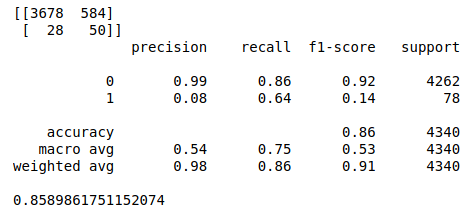

In [97]:
print('Measuring the time to complete this task:')
print((time.time() - start_time)/60) ## koniec pomiaru czasu

Measuring the time to complete this task:
2.6836975534756977
